## Yandex Cloud

Облако Yandex Cloud содержит множество сервисов для выполнения базовых операций. Ниже мы приведём несколько "строительных блоков" в виде кусочков кода на Python, которые вы сможете использовать в своих проектах.

Для дальнейшей работы потребуются ключи для доступа к облаку: `folder_id` и `api_key`. Мы будем предполагать, что эти ключи записаны в секретах датасферы:

In [2]:
import os

folder_id  = os.environ['folder_id']
api_key = os.environ['api_key']

print(f"Используем folder_id = {folder_id}")

Используем folder_id = b1gst3c7cskk2big5fqn


### Устанавливаем необходимые библиотеки

Для начала надо установить необходимые библиотеки Python, которые понадобятся нам в работе.

In [ ]:
%pip install yandex_chain

### Использование больших языковых моделей

In [4]:
from yandex_chain import YandexGPTModel, YandexLLM

gpt = YandexLLM(folder_id=folder_id, api_key=api_key,model=YandexGPTModel.Pro)

print(gpt.invoke('Привет! Придумай 10 новых слов для приветствия.'))

Конечно, вот несколько вариантов слов для приветствия:

1. Приветствие!
2. Доброго времени!
3. Свет дня вам!
4. Здравасьте!
5. Утро доброе!
6. Здравствуйте и процветайте!
7. Навстречу вам!
8. Здравия желаю!
9. Добро пожаловать в мой мир!
10. Здравствуйте и не болейте!


Alternative(role='assistant', text='— Вовочка, назови два местоимения.— Кто, я?', status=<AlternativeStatus.FINAL: 3>)


### Работаем с Yandex Cloud

Для работы с другими сервисами Yandex Cloud надо использовать специальные протоколы общения - REST. Ниже пара функций, которые помогут нам в дальнейшем вызывать разные функции в облаке:

In [5]:
import requests
import os

def call_api(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.post(url, json=data, headers=headers).json()

def call_api_get(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.get(url, headers=headers).json()

### YandexART

YandexART - это сеть для рисования картинок. Она работает следующим образом:
* Мы делаем запрос на рисование картинки, передавая текстовое описание того, что мы хотим нарисовать
* В ответ получаем набор букв - идентификатор задачи
* По идентификатору задачи мы можем проверять, готова ли картинка, и скачивать её.

Вот функция для подачи запроса:

In [6]:
def submit_art(prompt):
    res = call_api("https://llm.api.cloud.yandex.net/foundationModels/v1/imageGenerationAsync",
    {
        "modelUri": f"art://{folder_id}/yandex-art/latest",
        "messages": [
          {
            "weight": 1,
            "text": prompt
          }
        ]
    })
    if 'error' in res:
        print(res)
        return None
    return res['id']

id = submit_art('Нарисуй ёжика в тумане')
print(id)

fbvlka9g8seq79ee3u4v


Для скачивания картинки используем функцию `check`:

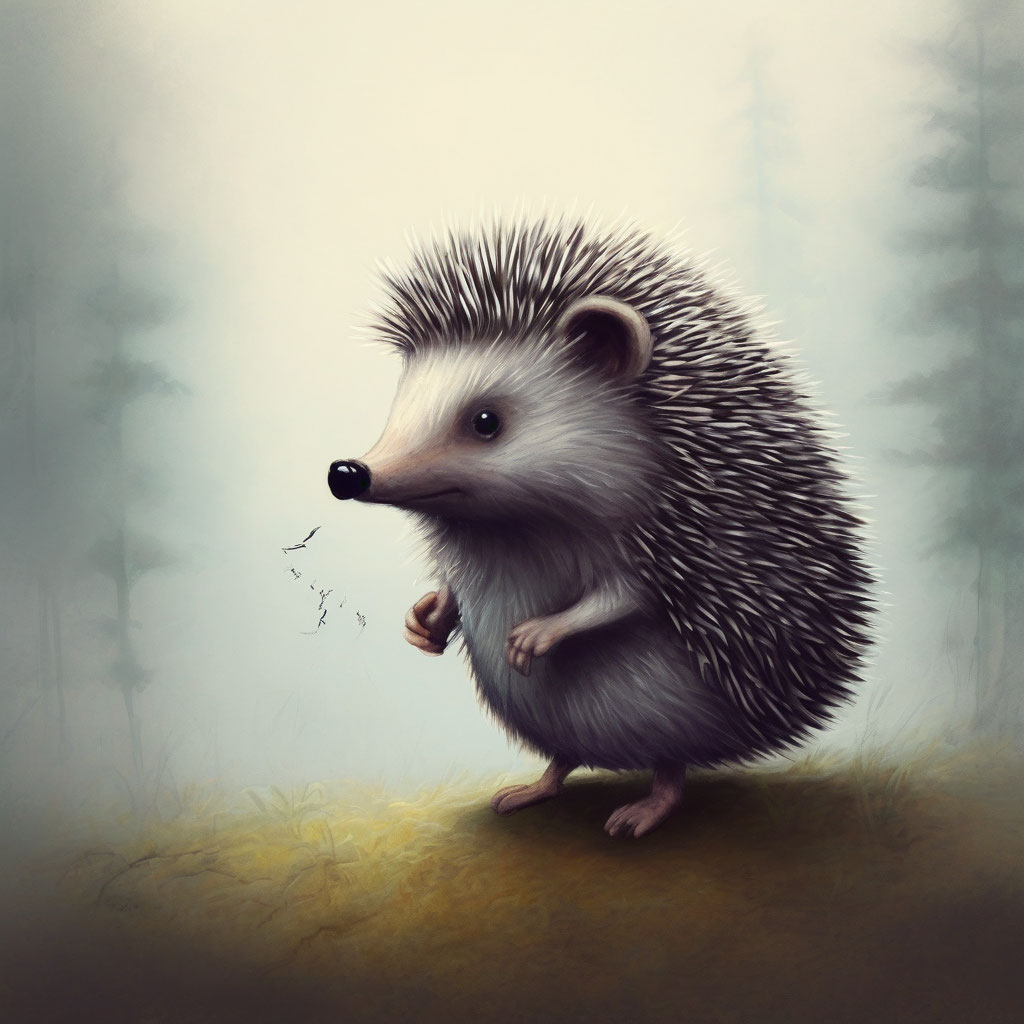

In [7]:
import io
from PIL import Image
import base64

def decode_image(base64_str):
    return Image.open(io.BytesIO(base64.decodebytes(bytes(base64_str, "utf-8"))))

def check(id):
    res = call_api_get(f"https://llm.api.cloud.yandex.net:443/operations/{id}",{})
    if 'done' in res and res['done']:
        return decode_image(res['response']['image'])
    else:
        return None
    
res = check(id)
res

Теперь объединим эти функции вместе и добавим ожидание:

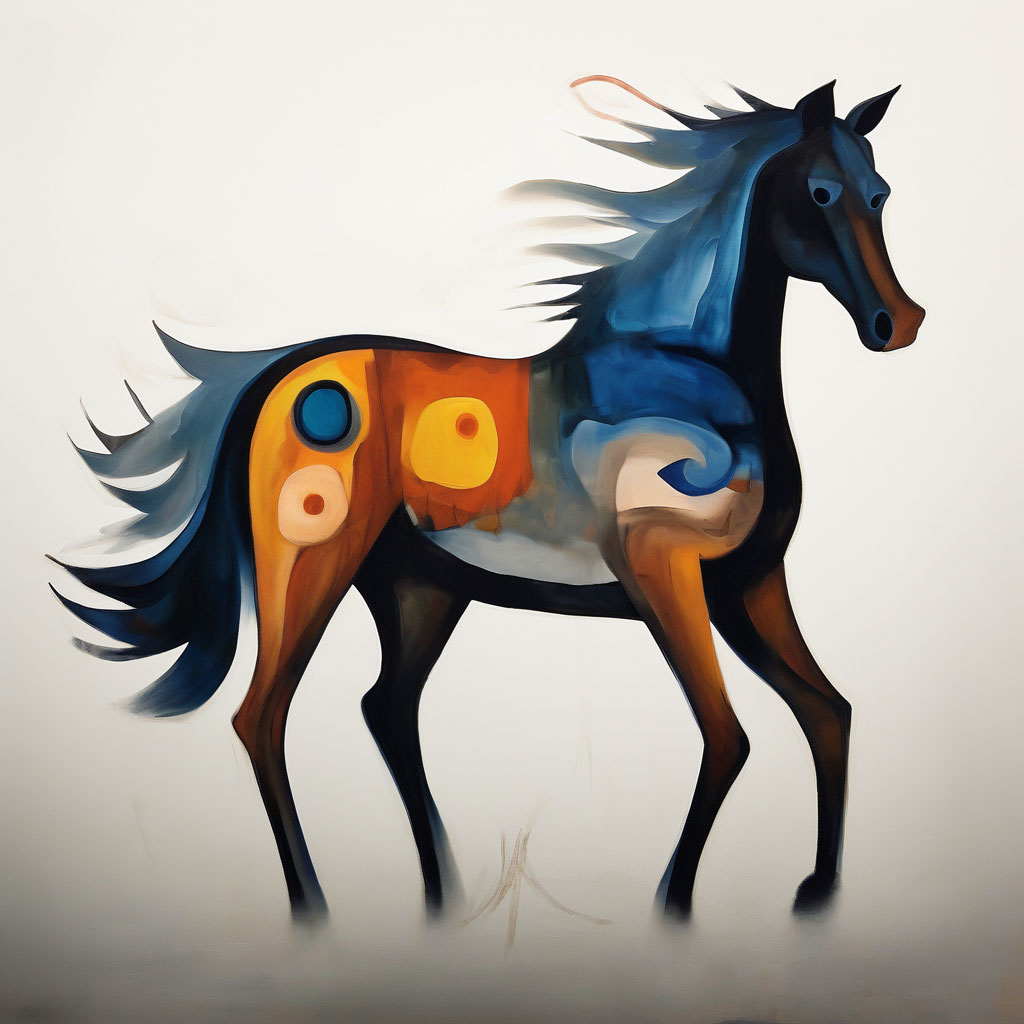

In [9]:
import time

def draw_picture(txt):
    id = submit_art(txt)
    while True:
        time.sleep(10)
        res = check(id)
        if res:
            return res

draw_picture('Лошадка в тумане в стиле Пикассо')

Чуть более сложная функция для рисования сразу нескольких запросов:

In [13]:
def draw_pictures(l):
    d = { x : submit_art(x) for x in l }
    res = {}
    while True:
        time.sleep(10)
        if len(d.keys())==0:
            return res
        for k,v in d.items():
            r = check(v)
            if r:
                res[k] = r
                d[k] = None
        d = { k: v for k,v in d.items() if v is not None }
                
                
draw_pictures(['Ёжик в тумане','Лошадка в тумане'])

{'Ёжик в тумане': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024>,
 'Лошадка в тумане': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024>}

### Распознаём текст на картинке

Для распознавания текста на картике служит сервис Yandex Vision OCR. Рассмотрим следующую картинку:

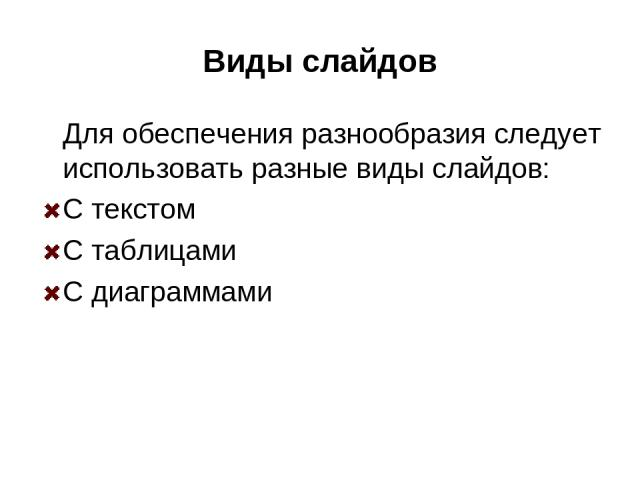

In [18]:
img = Image.open('images/slide.jpg')
img

In [26]:
from io import BytesIO

def ocr(img):
    buffer = BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()

    j = {
      "mimeType": "JPEG",
      "languageCodes": ["*"],
      "model": "page",
      "content": base64.b64encode(myimage).decode('utf-8')
    }
    res = call_api("https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText",j)
    return res

ocr(img)

{'result': {'textAnnotation': {'width': '640',
   'height': '480',
   'blocks': [{'boundingBox': {'vertices': [{'x': '200', 'y': '53'},
       {'x': '200', 'y': '71'},
       {'x': '430', 'y': '71'},
       {'x': '430', 'y': '53'}]},
     'lines': [{'boundingBox': {'vertices': [{'x': '200', 'y': '53'},
         {'x': '200', 'y': '71'},
         {'x': '430', 'y': '71'},
         {'x': '430', 'y': '53'}]},
       'text': 'Виды слайдов',
       'words': [{'boundingBox': {'vertices': [{'x': '200', 'y': '51'},
           {'x': '200', 'y': '75'},
           {'x': '277', 'y': '75'},
           {'x': '277', 'y': '51'}]},
         'text': 'Виды',
         'entityIndex': '-1',
         'textSegments': [{'startIndex': '0', 'length': '4'}]},
        {'boundingBox': {'vertices': [{'x': '294', 'y': '51'},
           {'x': '294', 'y': '75'},
           {'x': '430', 'y': '75'},
           {'x': '430', 'y': '51'}]},
         'text': 'слайдов',
         'entityIndex': '-1',
         'textSegments': [{'s

Чтобы получить только текст, используем такой вариант:

In [30]:
def ocr_text(img):
    res = ocr(img)
    return res['result']['textAnnotation']['fullText']

ocr_text(img)

'Виды слайдов\nДля обеспечения разнообразия следует\nиспользовать разные виды слайдов:\n×С текстом\n×С таблицами\n×С диаграммами\n'